HELLO

In [38]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

from simulation.helpers import (
    collect_metrics_once,
    collect_metrics_many
)
from distributions import sample_truncated_normal

# -------------------
# Parameters
# -------------------
ARRIVAL_RATE = 10        # λ = 10 travelers per minute
SERVICE_TIME = 0.5       # average service time (minutes per traveler, 30s)
SERVICE_RATE = 1 / SERVICE_TIME   # μ = 2 travelers per minute
RUN_UNTIL = 500          # number of arrivals to simulate in each run
REPLICATIONS = 500       # number of independent runs per setting
QUEUE_OPTIONS = [1, 2, 4, 6, 8, 10, 12]


In [39]:
# Service time distributions
service_distribution = (0.5, 1/6)             # mean 0.5 min, std 0.167
additional_screening_distribution = (2.0, 2.0) # mean 2 min, std 2

In [40]:
empirical_no_screening = {}
empirical_with_screening = {}

for stations in QUEUE_OPTIONS:
    # Without additional screening
    empirical_no_screening[stations] = collect_metrics_many(
        ARRIVAL_RATE, SERVICE_RATE, RUN_UNTIL,
        num_queues=stations,
        service_distribution=service_distribution,
        additional_screening_distribution=None,
        num_replications=REPLICATIONS
    )

    # With additional screening
    empirical_with_screening[stations] = collect_metrics_many(
        ARRIVAL_RATE, SERVICE_RATE, RUN_UNTIL,
        num_queues=stations,
        service_distribution=service_distribution,
        additional_screening_distribution=additional_screening_distribution,
        num_replications=REPLICATIONS
    )


In [41]:
# -------------------
# Format results
# -------------------
def format_results(results_dict, metric):
    rows = []
    for stations, metrics in results_dict.items():
        mean, low, high = metrics[metric]
        rows.append([stations, mean, low, high])
    return pd.DataFrame(rows, columns=["Stations", "Mean", "CI Low", "CI High"])


In [42]:
# Waiting time
df_wait_no_screening = format_results(empirical_no_screening, "avg_waiting_time")
df_wait_with_screening = format_results(empirical_with_screening, "avg_waiting_time")

# Average queue length
df_queue_no_screening = format_results(empirical_no_screening, "avg_queue_length")
df_queue_with_screening = format_results(empirical_with_screening, "avg_queue_length")

# Maximum queue length
df_max_no_screening = format_results(empirical_no_screening, "max_queue_length")
df_max_with_screening = format_results(empirical_with_screening, "max_queue_length")


In [43]:
# -------------------
# Theoretical formulas
# -------------------
def theoretical_mg1_wait(lam, mean_s, var_s):
    """Pollaczek–Khinchine: average waiting time in queue for M/G/1."""
    rho = lam * mean_s
    if rho >= 1:
        return np.inf
    ES2 = var_s + mean_s**2
    return lam * ES2 / (2 * (1 - rho))

def theoretical_multi_server(arrival_rate, mean_s, var_s, c):
    """
    Approximate parallel M/G/1 queues by splitting arrivals evenly.
    Returns:
      Wq_total  : average waiting time (minutes)
      Lq_total  : average # waiting (across all queues)
      L_total   : average # in system (waiting + in service)
    """
    lam_per = arrival_rate / c
    Wq = theoretical_mg1_wait(lam_per, mean_s, var_s)          # per-station wait
    Lq_per = lam_per * Wq                                       # Little's Law (per station)
    Lq_total = c * Lq_per
    rho = lam_per * mean_s
    L_per = Lq_per + rho                                        # add 'in service' per station
    L_total = c * L_per
    return Wq, Lq_total, L_total

def add_screening_effect(mean_s, var_s, p=0.03, mean_extra=2.0, var_extra=4.0):
    """
    Adjust mean/variance when an extra Bernoulli(p) * B is added to service time.
    E[S'] = E[S] + p*E[B]
    Var(S') = Var(S) + Var(I*B) where Var(I*B) = p*(Var(B)+E[B]^2) - (p*E[B])^2
    """
    mean_new = mean_s + p * mean_extra
    extra_var = p * (var_extra + mean_extra**2) - (p * mean_extra)**2
    var_new = var_s + extra_var
    return mean_new, var_new

def theory_tables(queue_options, arrival_rate, mean_s, var_s,
                  p=0.03, mean_extra=2.0, var_extra=4.0):
    """Compute theory for all c in queue_options, with/without screening."""
    rows_no, rows_yes = [], []
    for c in queue_options:
        # no screening
        Wq, Lq, L = theoretical_multi_server(arrival_rate, mean_s, var_s, c)
        rows_no.append([c, Wq, Lq, L])

        # with screening
        mean_s2, var_s2 = add_screening_effect(mean_s, var_s, p, mean_extra, var_extra)
        Wq2, Lq2, L2 = theoretical_multi_server(arrival_rate, mean_s2, var_s2, c)
        rows_yes.append([c, Wq2, Lq2, L2])

    cols = ["Stations", "Wq (min)", "Lq (waiting only)", "L (system)"]
    import pandas as pd
    df_no = pd.DataFrame(rows_no, columns=cols)
    df_yes = pd.DataFrame(rows_yes, columns=cols)
    return df_no, df_yes


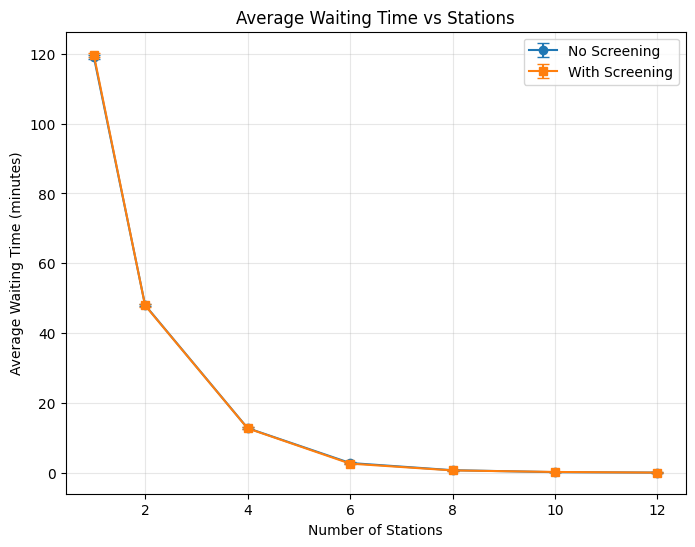

In [44]:
# -------------------
# Plots
# -------------------

# 1. Waiting time vs Stations
plt.figure(figsize=(8,6))
plt.errorbar(
    df_wait_no_screening["Stations"], df_wait_no_screening["Mean"],
    yerr=[
        df_wait_no_screening["Mean"] - df_wait_no_screening["CI Low"],
        df_wait_no_screening["CI High"] - df_wait_no_screening["Mean"]
    ],
    label="No Screening", fmt="o-", capsize=4
)
plt.errorbar(
    df_wait_with_screening["Stations"], df_wait_with_screening["Mean"],
    yerr=[
        df_wait_with_screening["Mean"] - df_wait_with_screening["CI Low"],
        df_wait_with_screening["CI High"] - df_wait_with_screening["Mean"]
    ],
    label="With Screening", fmt="s-", capsize=4
)
plt.title("Average Waiting Time vs Stations")
plt.xlabel("Number of Stations")
plt.ylabel("Average Waiting Time (minutes)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


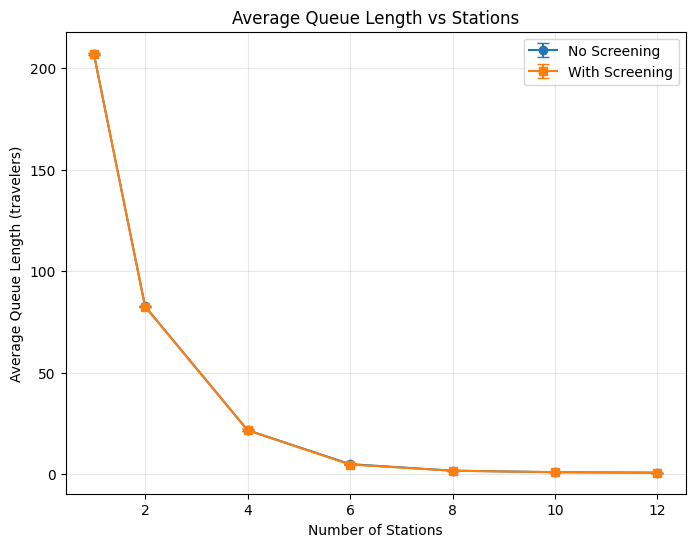

In [45]:
# 2. Average queue length vs Stations
plt.figure(figsize=(8,6))
plt.errorbar(
    df_queue_no_screening["Stations"], df_queue_no_screening["Mean"],
    yerr=[
        df_queue_no_screening["Mean"] - df_queue_no_screening["CI Low"],
        df_queue_no_screening["CI High"] - df_queue_no_screening["Mean"]
    ],
    label="No Screening", fmt="o-", capsize=4
)
plt.errorbar(
    df_queue_with_screening["Stations"], df_queue_with_screening["Mean"],
    yerr=[
        df_queue_with_screening["Mean"] - df_queue_with_screening["CI Low"],
        df_queue_with_screening["CI High"] - df_queue_with_screening["Mean"]
    ],
    label="With Screening", fmt="s-", capsize=4
)
plt.title("Average Queue Length vs Stations")
plt.xlabel("Number of Stations")
plt.ylabel("Average Queue Length (travelers)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

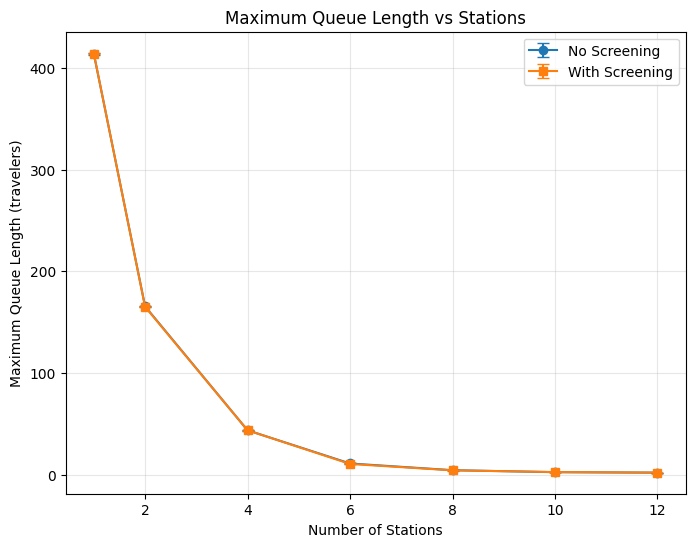

In [46]:
# 3. Maximum queue length vs Stations
plt.figure(figsize=(8,6))
plt.errorbar(
    df_max_no_screening["Stations"], df_max_no_screening["Mean"],
    yerr=[
        df_max_no_screening["Mean"] - df_max_no_screening["CI Low"],
        df_max_no_screening["CI High"] - df_max_no_screening["Mean"]
    ],
    label="No Screening", fmt="o-", capsize=4
)
plt.errorbar(
    df_max_with_screening["Stations"], df_max_with_screening["Mean"],
    yerr=[
        df_max_with_screening["Mean"] - df_max_with_screening["CI Low"],
        df_max_with_screening["CI High"] - df_max_with_screening["Mean"]
    ],
    label="With Screening", fmt="s-", capsize=4
)
plt.title("Maximum Queue Length vs Stations")
plt.xlabel("Number of Stations")
plt.ylabel("Maximum Queue Length (travelers)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [49]:
# -------------------
# Generate theory tables for comparison
# -------------------
theory_no_screen, theory_with_screen = theory_tables(
    QUEUE_OPTIONS, ARRIVAL_RATE, mean_s=0.5, var_s=(1/6)**2,
    p=0.03, mean_extra=2.0, var_extra=4.0
)
print("Theoretical Results Without Screening:")
display(theory_no_screen)
print("\nTheoretical Results With Screening:")
display(theory_with_screen)


Theoretical Results Without Screening:


,Stations,Wq (min),Lq (waiting only),L (system)
0,1,inf,inf,inf
1,2,inf,inf,inf
2,4,inf,inf,inf
3,6,1.388889,13.888889,18.888889
4,8,0.462963,4.629630,9.629630
5,10,0.277778,2.777778,7.777778
6,12,0.198413,1.984127,6.984127



Theoretical Results With Screening:


,Stations,Wq (min),Lq (waiting only),L (system)
0,1,inf,inf,inf
1,2,inf,inf,inf
2,4,inf,inf,inf
3,6,7.222222,72.222222,77.822222
4,8,1.203704,12.037037,17.637037
5,10,0.656566,6.565657,12.165657
6,12,0.451389,4.513889,10.113889


In [48]:
# -------------------
# Theory vs Simulation Comparison (6, 8, 10 stations)
# -------------------
comparison = []
for stations in [6, 8, 10]:
    sim_no = empirical_no_screening[stations]["avg_waiting_time"][0]
    sim_yes = empirical_with_screening[stations]["avg_waiting_time"][0]

    theory_no = theory_no_screen.loc[theory_no_screen["Stations"]==stations, "Wq (min)"].values[0]
    theory_yes = theory_with_screen.loc[theory_with_screen["Stations"]==stations, "Wq (min)"].values[0]

    comparison.append([stations, theory_no, sim_no, theory_yes, sim_yes])

df_comparison = pd.DataFrame(
    comparison,
    columns=["Stations", "Theoretical Wait", "Empirical Wait",
             "Theoretical Wait (Screen)", "Empirical Wait (Screen)"]
)
display(df_comparison)


,Stations,Theoretical Wait,Empirical Wait,Theoretical Wait (Screen),Empirical Wait (Screen)
0,6,1.388889,2.865010,7.222222,2.690436
1,8,0.462963,0.804321,1.203704,0.743532
2,10,0.277778,0.244085,0.656566,0.298294
